# Linearly decoded VAE

This notebook shows how to use the 'linearly decoded VAE' model which explicitly links latent variables of cells to genes.

The scVI model learns low-dimensional latent representations of cells which get mapped to parameters of probability distributions which can generate counts consistent to what is observed from data. In the standard version of scVI these parameters for each gene and cell arise from applying neural networks to the latent variables. Neural networks are flexible and can represent non-linearities in the data. This comes at a price, there is no direct link between a latent variable dimension and any potential set of genes which would covary across it.

The `LDVAE` model replaces the neural networks with linear functions. Now a higher value along a latent dimension will directly correspond to higher expression of the genes with high weights assigned to that dimension.

This leads to a generative model comparable to probabilistic PCA or factor analysis, but generates counts rather than real numbers. Using the framework of scVI also allows variational inference which scales to very large datasets and can make use of GPUs for additional speed.

This notebook demonstrates how to fit an `LDVAE` model to scRNA-seq data, plot the latent variables, and interpret which genes are linked to latent variables.

As an example, we use the PBMC 10K from 10x Genomics.

Uncomment the following lines in Google Colab in order to install `scvi-tools`:

In [1]:
# !pip install --quiet scvi-colab
# from scvi_colab import install

# install()

In [2]:
import os
import tempfile

import matplotlib.pyplot as plt
import scanpy as sc
import scvi
import torch

In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Last run with scvi-tools version: 1.0.3


You can modify `save_dir` below to change where the data files for this tutorial are saved.

In [4]:
sc.set_figure_params(figsize=(4, 4), frameon=False)
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor" : "w"}
%config InlineBackend.figure_format="retina"

## Initialization

Load data and select the top 1000 variable genes with seurat_v3 method

In [5]:
adata_path = os.path.join(save_dir.name, "pbmc_10k_protein_v3.h5ad")
adata = sc.read(
    adata_path,
    backup_url="https://github.com/YosefLab/scVI-data/raw/master/pbmc_10k_protein_v3.h5ad?raw=true",
)

adata

  0%|          | 0.00/23.8M [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 6855 × 16727
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells', 'highly_variable', 'encode', 'hvg_encode'
    uns: 'protein_names'
    obsm: 'protein_expression'

In [6]:
adata.layers["counts"] = adata.X.copy()  # preserve counts
sc.pp.normalize_total(adata, target_sum=10e4)
sc.pp.log1p(adata)
adata.raw = adata  # freeze the state in `.raw`

sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", layer="counts", n_top_genes=1000, subset=True
)

## Create and fit `LDVAE` model

First subsample 1,000 genes from the original data.

Then we initialize an `LinearSCVI` model. Here we set the latent space to have 10 dimensions.

In [7]:
scvi.model.LinearSCVI.setup_anndata(adata, layer="counts")
model = scvi.model.LinearSCVI(adata, n_latent=10)

In [8]:
model.train(max_epochs=250, plan_kwargs={"lr": 5e-3}, check_val_every_n_epoch=10)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 250/250: 100%|██████████| 250/250 [01:06<00:00,  3.74it/s, v_num=1, train_loss_step=337, train_loss_epoch=376]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 250/250: 100%|██████████| 250/250 [01:06<00:00,  3.78it/s, v_num=1, train_loss_step=337, train_loss_epoch=376]


Inspecting the convergence

<Axes: xlabel='epoch'>

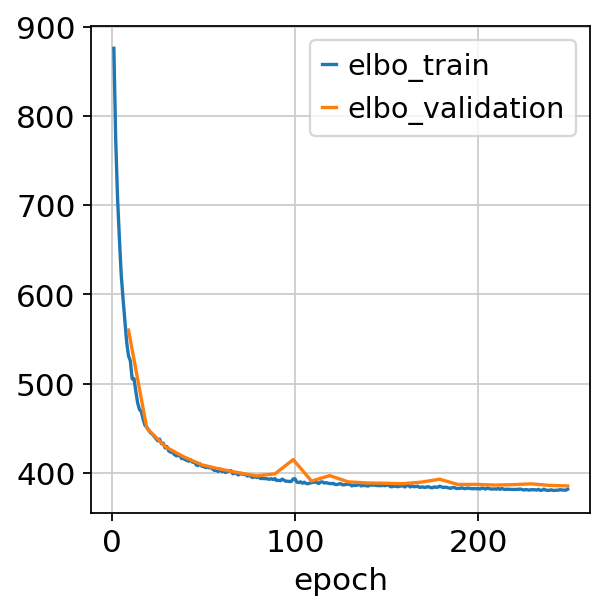

In [9]:
train_elbo = model.history["elbo_train"][1:]
test_elbo = model.history["elbo_validation"]

ax = train_elbo.plot()
test_elbo.plot(ax=ax)

## Extract and plot latent dimensions for cells

From the fitted model we extract the (mean) values for the latent dimensions. We store the values in the AnnData object for convenience.

In [10]:
Z_hat = model.get_latent_representation()
for i, z in enumerate(Z_hat.T):
    adata.obs[f"Z_{i}"] = z

Now we can plot the latent dimension coordinates for each cell. A quick (albeit not complete) way to view these is to make a series of 2D scatter plots that cover all the dimensions. Since we are representing the cells by 10 dimensions, this leads to 5 scatter plots.

/tmp/ipykernel_934170/650095484.py:22: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgd.legendHandles:


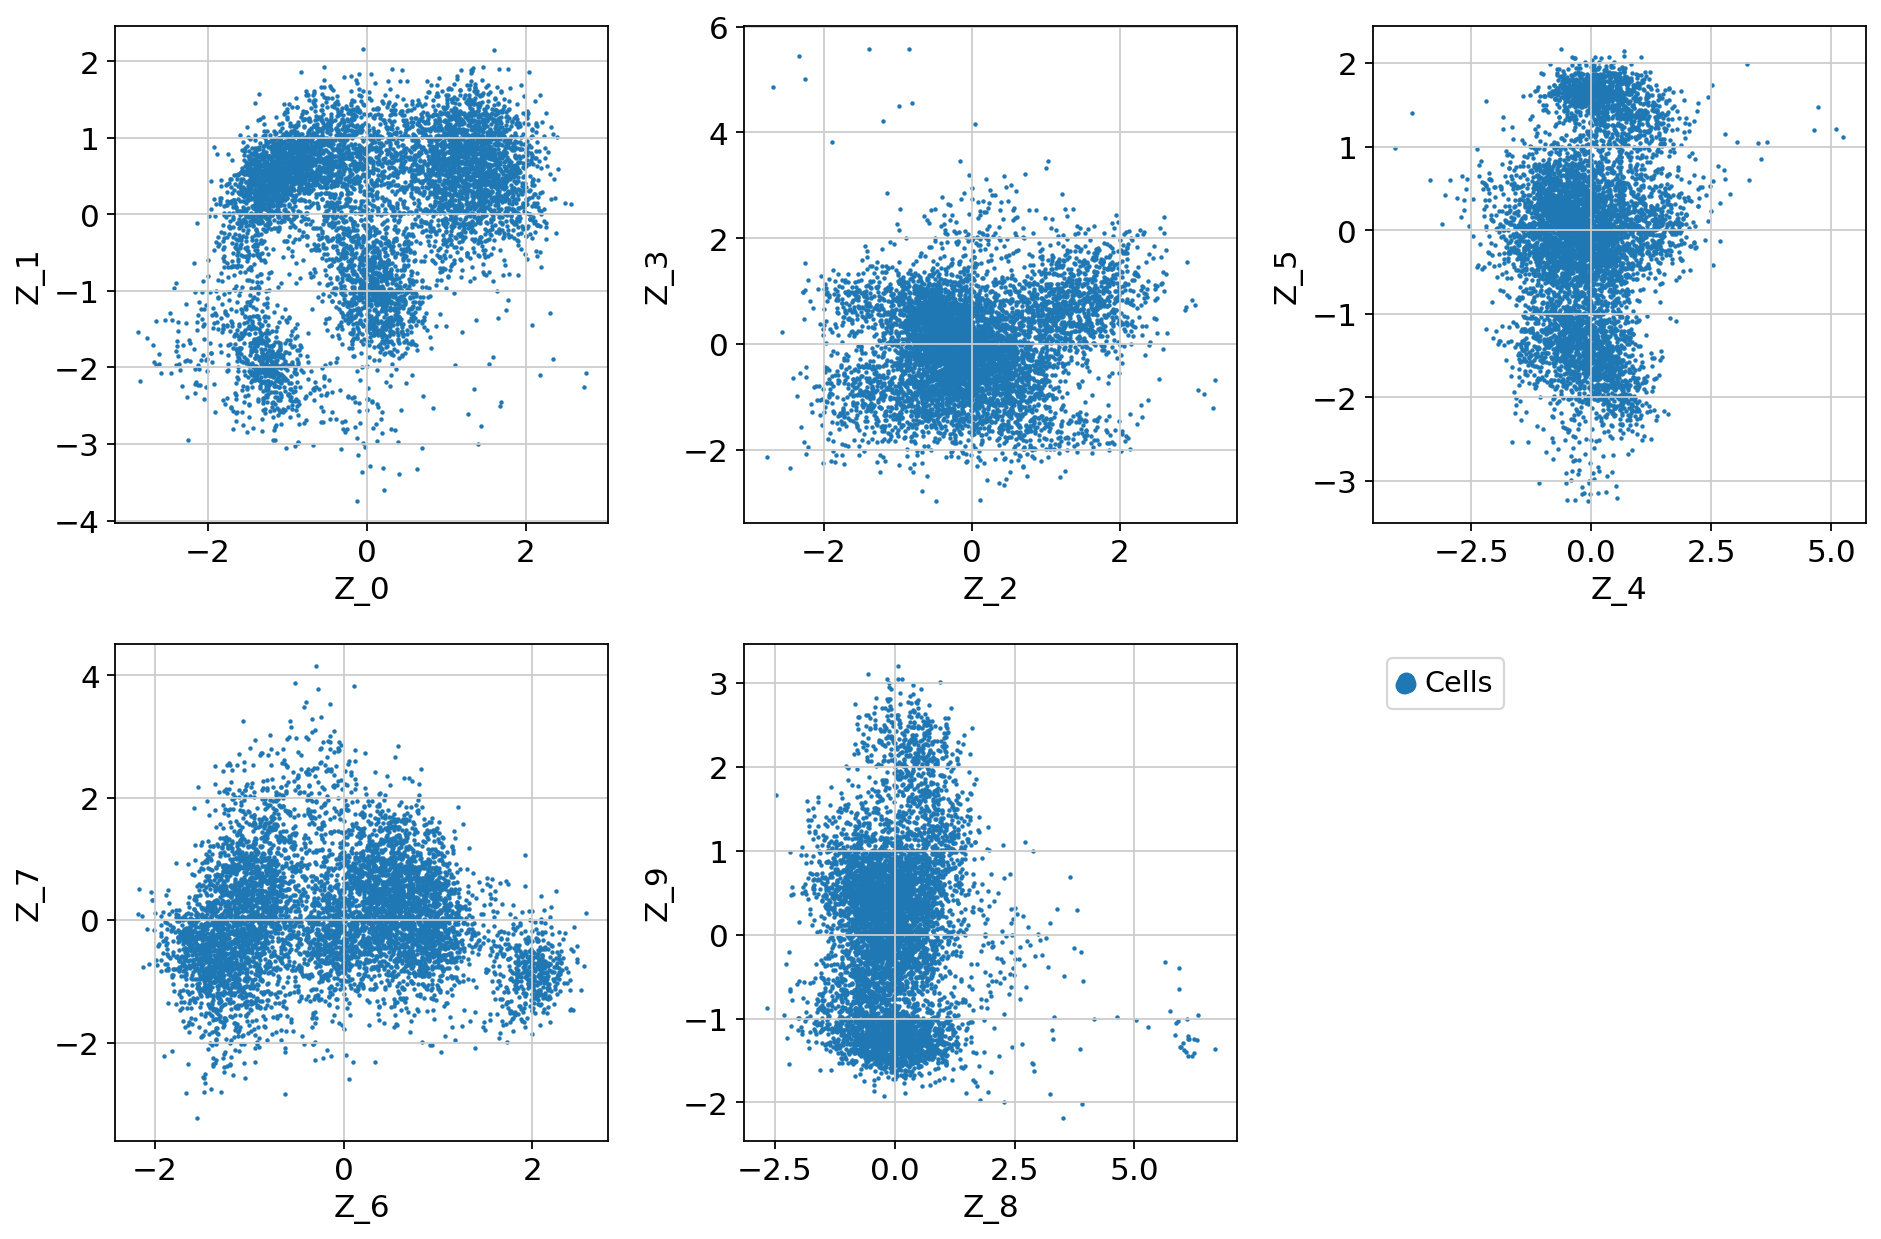

In [11]:
fig = plt.figure(figsize=(12, 8))

for f in range(0, 9, 2):
    plt.subplot(2, 3, int(f / 2) + 1)

    plt.scatter(
        adata.obs[f"Z_{f}"], adata.obs[f"Z_{f + 1}"], marker=".", s=4, label="Cells"
    )

    plt.xlabel(f"Z_{f}")
    plt.ylabel(f"Z_{f + 1}")

plt.subplot(2, 3, 6)
plt.scatter(
    adata.obs[f"Z_{f}"], adata.obs[f"Z_{f + 1}"], marker=".", label="Cells", s=4
)
plt.scatter(adata.obs[f"Z_{f}"], adata.obs[f"Z_{f + 1}"], c="w", label=None)
plt.gca().set_frame_on(False)
plt.gca().axis("off")

lgd = plt.legend(scatterpoints=3, loc="upper left")
for handle in lgd.legendHandles:
    handle.set_sizes([200])


plt.tight_layout()

The question now is how does the latent dimensions link to genes?

For a given cell x, the expression of the gene g is proportional to x_g = w\_(1, g) * z_1 + ... + w\_(10, g) * z_10. Moving from low values to high values in z_1 will mostly affect expression of genes with large w\_(1, :) weights. We can extract these weights from the `LDVAE` model, and identify which genes have high weights for each latent dimension.

In [12]:
loadings = model.get_loadings()
loadings.head()

,Z_0,Z_1,Z_2,Z_3,Z_4,Z_5,Z_6,Z_7,Z_8,Z_9
index,,,,,,,,,,
AL645608.8,0.714082,0.085754,0.225370,-0.263079,0.015618,-0.631942,-0.048701,-0.683085,-0.154336,0.068917
HES4,0.595488,-0.207024,0.289687,-0.727422,-0.188713,-0.502687,0.081659,-0.352091,-0.343553,-0.167613
ISG15,0.657707,0.190047,0.215027,-0.312993,-0.168181,0.198923,0.207224,-0.022024,-0.087437,0.115364
TNFRSF18,0.705759,-0.125003,1.340723,-0.066455,-0.328110,0.889547,0.559839,-0.515061,0.328291,1.048386
TNFRSF4,1.185758,0.232257,1.248926,-0.193232,-0.390461,0.479120,0.727615,-0.144973,0.145073,0.700497


For every latent variable Z, we extract the genes with largest _magnitude_, and separate genes with large negative values from genes with large positive values. We print out the top 5 genes in each direction for each latent variable.

In [13]:
print(
    "Top loadings by magnitude\n---------------------------------------------------------------------------------------"
)
for clmn_ in loadings:
    loading_ = loadings[clmn_].sort_values()
    fstr = clmn_ + ":\t"
    fstr += "\t".join([f"{i}, {loading_[i]:.2}" for i in loading_.head(5).index])
    fstr += "\n\t...\n\t"
    fstr += "\t".join([f"{i}, {loading_[i]:.2}" for i in loading_.tail(5).index])
    print(
        fstr
        + "\n---------------------------------------------------------------------------------------\n"
    )

Top loadings by magnitude
---------------------------------------------------------------------------------------
Z_0:	IL1B, -1.1	FCER1A, -1.0	PTGS2, -1.0	CD1E, -0.91	CD1C, -0.91
	...
	MYOM2, 1.9	TRBC1, 1.9	CD40LG, 1.9	TSHZ2, 2.1	FOXP3, 2.1
---------------------------------------------------------------------------------------

Z_1:	C1QA, -0.83	HLA-DQA1, -0.79	PLD4, -0.73	MEG3, -0.72	PDLIM1, -0.71
	...
	KLRC1, 1.3	CD8A, 1.4	CXCL8, 1.4	G0S2, 1.4	CD8B, 1.5
---------------------------------------------------------------------------------------

Z_2:	CD8A, -1.1	CD8B, -1.0	LCNL1, -1.0	LINC02446, -0.98	TCL1A, -0.86
	...
	DUSP4, 1.3	TNFRSF18, 1.3	RTKN2, 1.4	LMNA, 1.5	IFI27, 1.7
---------------------------------------------------------------------------------------

Z_3:	S100B, -2.0	C1QB, -1.8	C1QA, -1.7	TRDC, -1.5	XCL1, -1.5
	...
	OSTN-AS1, 0.79	SHISA8, 0.82	IGLV1-51, 0.85	TNFRSF13B, 0.87	COCH, 1.0
---------------------------------------------------------------------------------------

Z_4:	R

It is important to keep in mind that unlike traditional PCA, these latent variables are not ordered. Z_0 does not necessarily explain more variance than Z_1.

These top genes can be interpreted as following most of the structural variation in the data.

The `LinearSCVI` model further supports the same scVI functionality as the `SCVI` model, so all posterior methods work the same. Here we show how to use scanpy to visualize the latent space.

In [14]:
SCVI_LATENT_KEY = "X_scVI"
SCVI_CLUSTERS_KEY = "leiden_scVI"

adata.obsm[SCVI_LATENT_KEY] = Z_hat
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY, n_neighbors=20)
sc.tl.umap(adata, min_dist=0.3)
sc.tl.leiden(adata, key_added=SCVI_CLUSTERS_KEY, resolution=0.8)

/home/martin/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/martin/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/martin/bin/mambaforge/envs/scvi-tools-

/home/martin/bin/mambaforge/envs/scvi-tools-dev/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


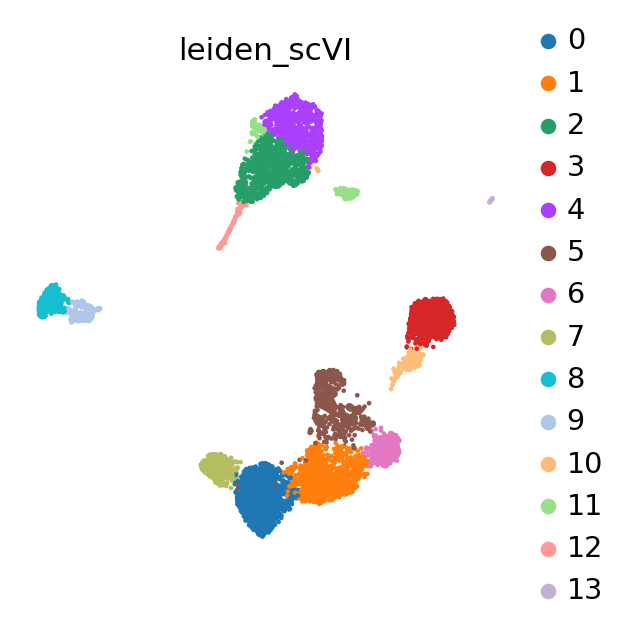

In [15]:
sc.pl.umap(adata, color=[SCVI_CLUSTERS_KEY])

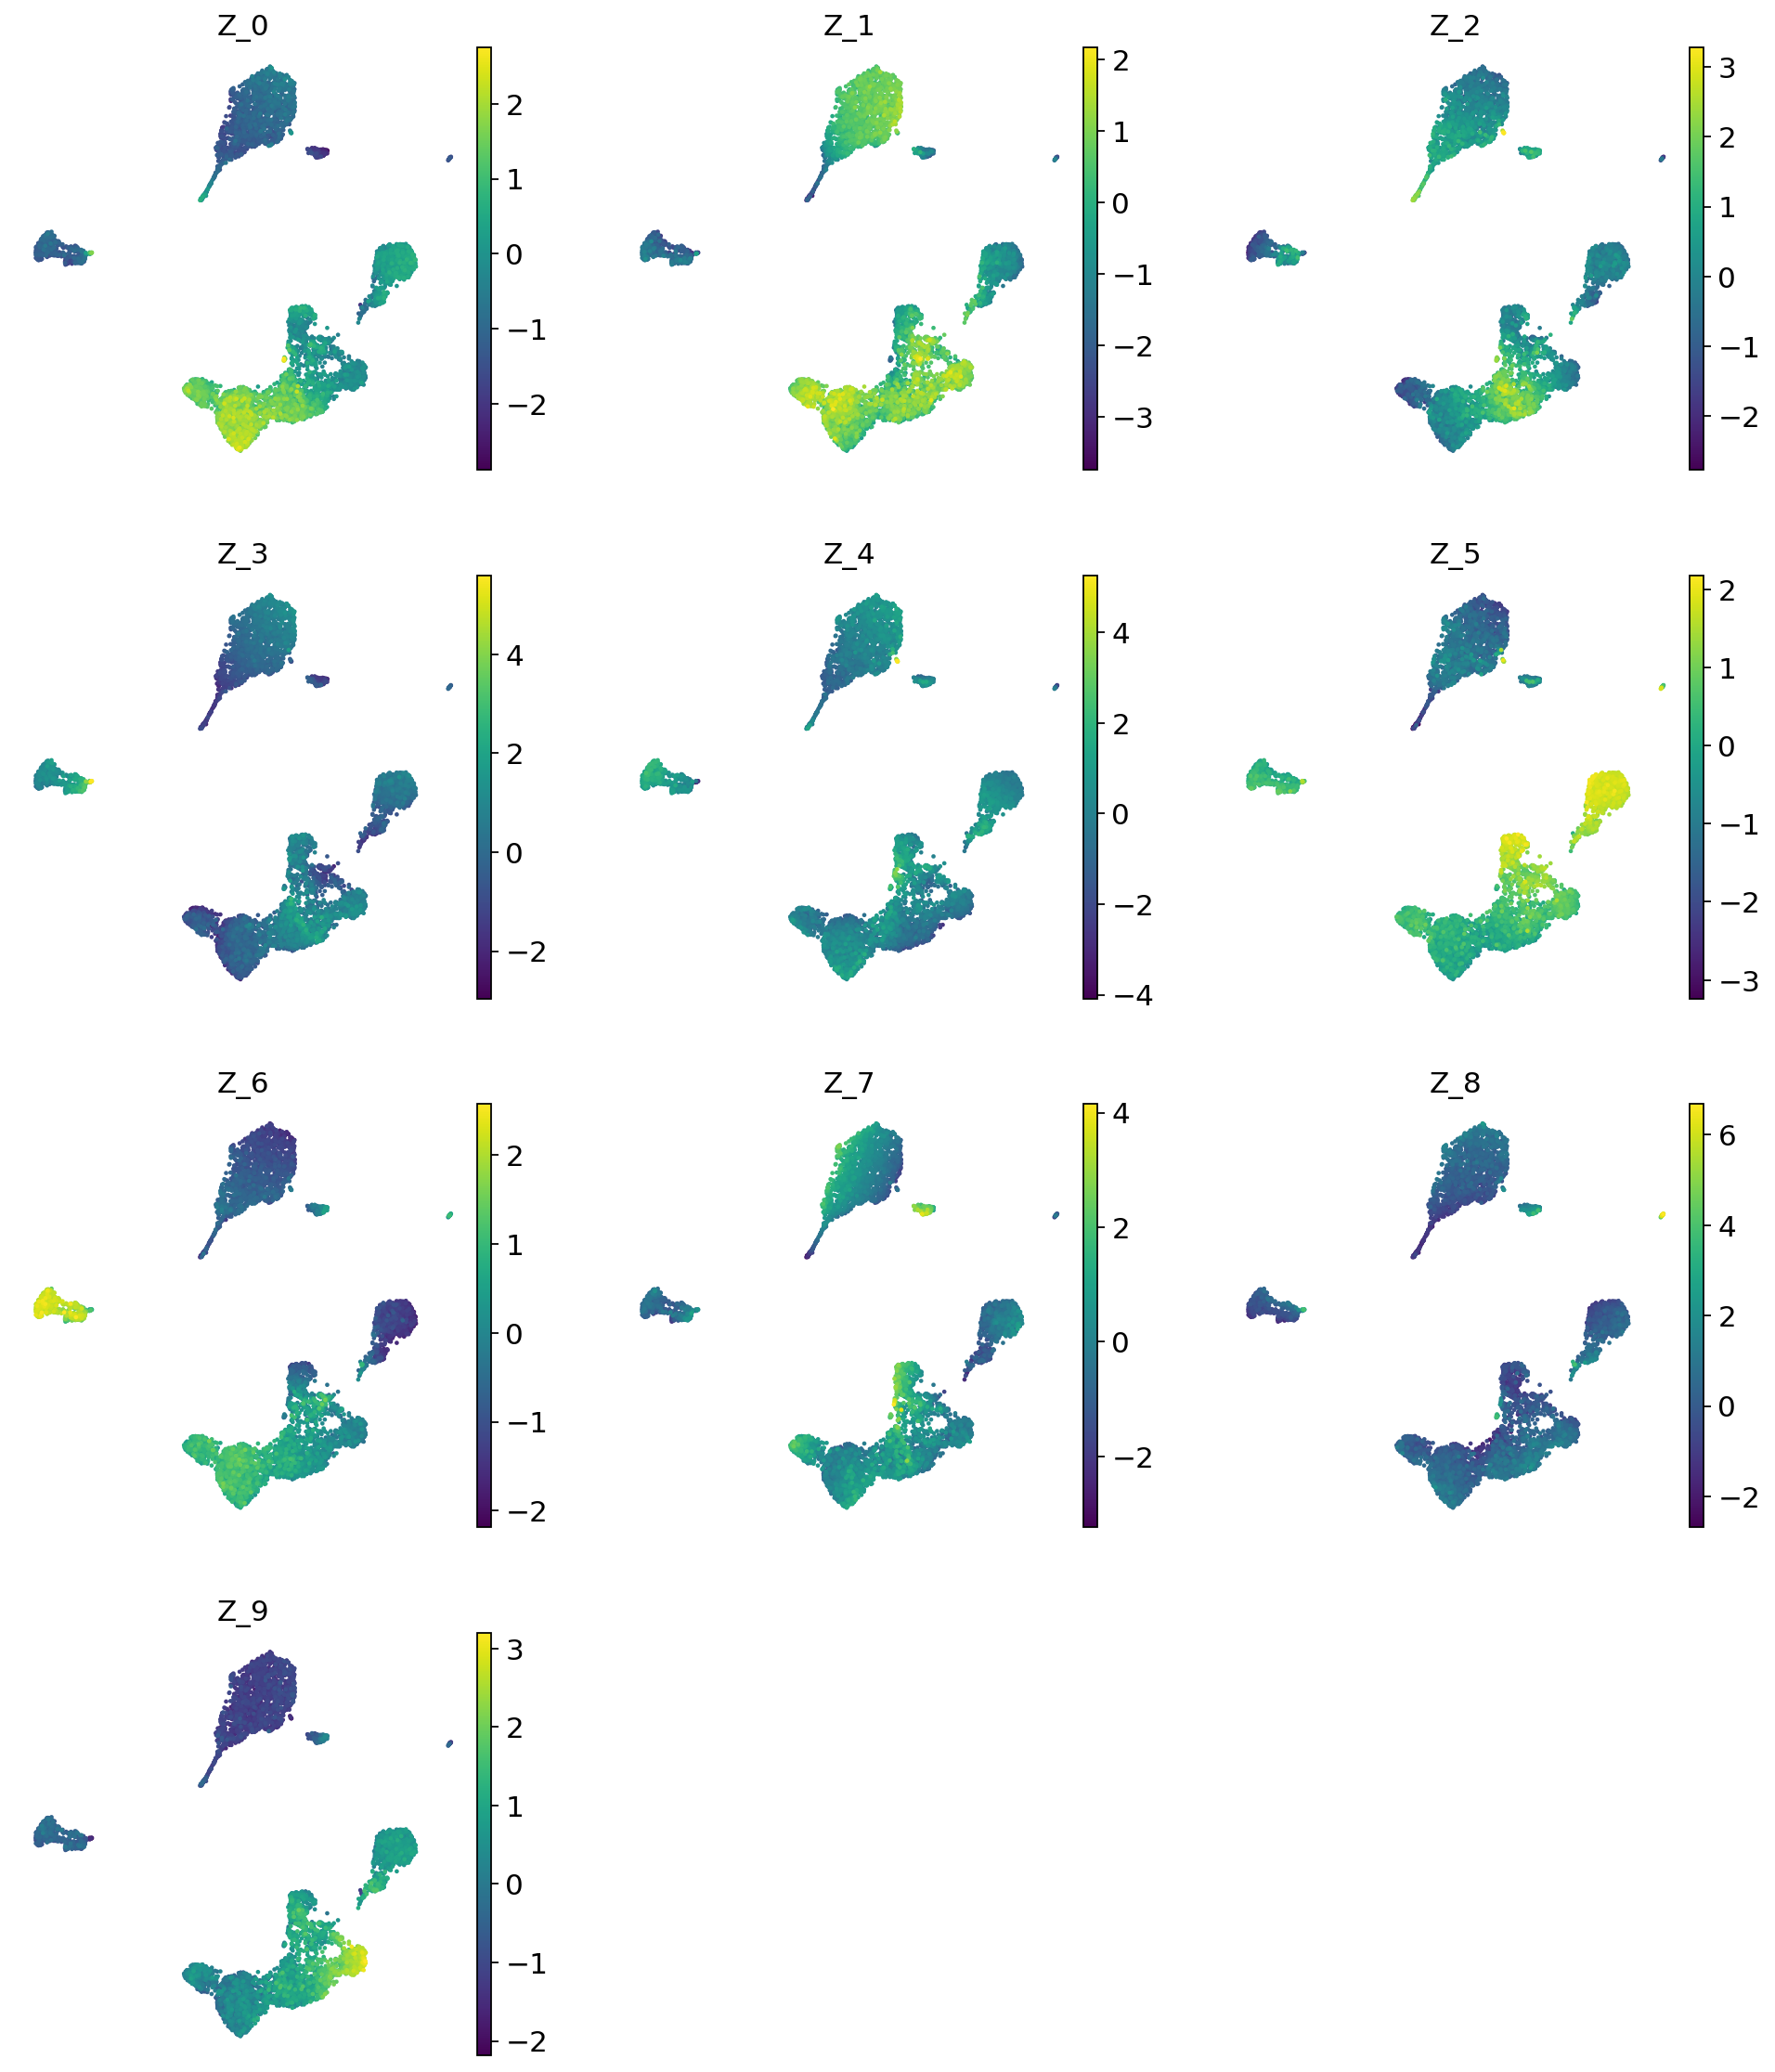

In [16]:
zs = [f"Z_{i}" for i in range(model.n_latent)]
sc.pl.umap(adata, color=zs, ncols=3)

## Clean up

Uncomment the following line to remove all data files created in this tutorial:

In [ ]:
# save_dir.cleanup()